In [13]:
import os
from dotenv import load_dotenv
from funzioni_albero_2025 import pausa,operazione_ERP,eliminazione_ERP,modifica_ERP,read_ERP, aes_decrypt,key,iv,fn_ricerca_ERP

from langchain_openai import ChatOpenAI
from langchain.agents import Tool
from langgraph.prebuilt import ToolNode,create_react_agent
from langchain_core.prompts import PromptTemplate
from langchain.memory import ConversationTokenBufferMemory
import ast

('ODOO CHATBOT', 91)


In [14]:
load_dotenv()
api_key = os.getenv("openai_key")

In [15]:
llm = ChatOpenAI(
    api_key=api_key,
    model='gpt-4o',
    temperature=0
)

In [16]:
memory = ConversationTokenBufferMemory(
    memory_key='chat_history',
    return_messages=True,
    llm=llm,
    max_token_limit=1000
    )

C:\Users\andre\AppData\Local\Temp\ipykernel_23464\2715650747.py:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationTokenBufferMemory(


In [17]:
def query_memory(input_text: str, memory=None):
    """
    Funzione per interpretare le richieste dell'utente relative al contesto.
    Ora riceve direttamente l'oggetto memory come parametro.
    """
    if memory is None:
        return input_text
        
    # Carica la chat history dalla memoria
    memory_vars = memory.load_memory_variables({})
    chat_history = memory_vars.get("chat_history", [])
    
    template = PromptTemplate.from_template(
        """
        Il tuo compito è RIFORMULARE la richiesta corrente dell'utente in una frase ESEGUIBILE, sostituendo riferimenti vaghi con informazioni specifiche dalla chat history.

        NON ANALIZZARE la chat history. NON DESCRIVERE cosa è stato fatto.
        INVECE, RIFORMULA la richiesta corrente in una nuova frase completa e autosufficiente.

        ESEMPI CORRETTI:
        Storia: "aggiungi due ore al foglio ore di oggi"
        Richiesta: "cancella l'ultima operazione"
        ✓ Output: "togli due ore al foglio ore di oggi"

        Storia: "registra check-in ore 9"
        Richiesta: "modifica l'orario"
        ✓ Output: "modifica l'orario del check-in di oggi dalle ore 9"

        ESEMPI ERRATI:
        Storia: "aggiungi due ore al foglio ore"
        Richiesta: "cancella l'ultima operazione"
        ✓ Output: "togli due ore al foglio ore"
        ✗ NO: "L'ultima operazione eseguita è stata l'aggiunta di due ore"
        ✗ NO: "Si procede a cancellare l'ultima operazione che era..."

        REGOLE:
        1. Inizia SEMPRE con un verbo d'azione
        2. Includi TUTTI i dettagli specifici dalla chat history
        3. La frase deve essere ESEGUIBILE come comando
        4. NON usare mai frasi descrittive o analitiche

        chat_history: {chat_history}
        richiesta corrente: {domanda}

        Riformula la richiesta in una singola frase eseguibile:
        """
    )
    
    chain_memory = template | llm
    print("memory")
    #print(chain_memory.invoke({"domanda": input_text, "chat_history": chat_history}).content)
    

    return chain_memory.invoke({"domanda": input_text, "chat_history": chat_history}).content

In [18]:
tools = [
    Tool(
        name="query_memory",
        func=lambda x: query_memory(x, memory),
        description="""
            Usa questo tool SOLO quando:
            - La richiesta contiene riferimenti vaghi ("quello", "questa", "precedente", "ultima")
            - Serve contestualizzare la richiesta con informazioni dalla chat history
            IMPORTANTE: Questo tool RIFORMULA la richiesta in un comando eseguibile
            
            Esempio INPUT: "cancella l'ultima operazione"
            Esempio OUTPUT: "togli 2 ore al foglio ore di oggi"
        """
    ),
    Tool(
        name="pausa",
        func=pausa,
        description="""
            Usa questo tool SOLO per:
            - Registrare check-in o check-out
            - Gestire pause pranzo
            - Registrare timbrature di entrata/uscita
            Non usare per:
            - Modificare timbrature esistenti (usa operazione_ERP)
            - Altre operazioni non legate a timbrature
            
            Esempio: "devo timbrare l'entrata" -> usa questo tool
            Esempio: "modifica la timbratura di ieri" -> usa operazione_ERP
        """
    ),
    Tool(
        name="operazione_ERP",
        func=operazione_ERP,
        description="""
            Usa questo tool per:
            - Creare nuovi record (richieste ferie, note spese, eventi in calendario ecc.)
            - Modificare record esistenti di qualsiasi tipo
            - Aggiornare informazioni nel sistema

            Non usare per:
            - Eliminare record (usa eliminazione_ERP)
            - Timbrature semplici (usa pausa)

            Esempio: "voglio prendere ferie lunedì" -> usa questo tool
            Esempio: "modifica l'importo della nota spese" -> usa questo tool
            Esempio: "togli due ore al foglio ore" -> usa questo tool
            Esempio: "crea un evento in calendario ..." -> usa questo tool
        """
    ),
    Tool(
        name="eliminazione_ERP",
        func=eliminazione_ERP,
        description="""
            Usa questo tool ESCLUSIVAMENTE per:
            - Eliminare definitivamente record dal sistema
            - Cancellare completamente una richiesta o un documento
            Usa SOLO quando l'utente richiede esplicitamente di:
            - Cancellare
            - Eliminare
            - Rimuovere
            Non usare mai per:
            - Modifiche o aggiornamenti (usa operazione_ERP)
            - Disattivazioni temporanee

            Esempio: "elimina la nota spese di ieri" -> usa questo tool
            Esempio: "rimuovi la richiesta ferie" -> usa questo tool
            Esempio: "togli un'ora dal foglio ore di oggi" --> non usare questo tool
        """
    ),
    Tool(
        name="modifica_ERP",
        func=modifica_ERP,
        description="""
            Usa questo tool esclusivamente per modificare i record del db 
            Usa SOLO quando l'utente richiede esplicitamente di:
            - Modificare
            - Cambiare
            - Spostare

            NOTA BENE: capisci quando usare questa funzione al posto di operazione_ERP; operazione_ERP serve per creare un record, modifica_ERP per modificare
            un record preesistente
            
            Esempio: "sposta la riunione di oggi a domani" -> usa questo tool
            Esempio: "cambia la data del meeting.." -> usa questo tool
            Esempio: "Elimina il meeting di oggi" -> non usare questo tool
        """
    ),
    Tool(
    name='read_ERP',
    func=read_ERP,
    description=""" 
        Usa questo tool esclusivamente per leggere e riportare record dal db.
        Usa SOLO quando l'utente chiede esplicitamente di:
        - Leggere
        - Mostrare
        - Riportare

        Se usi questa funzione poi dovrai usare anche la funzione 'plot'
        Esempio: "leggimi il foglio ore di oggi" -> usa questo tool
        Esempio: "mostrami gli eventi in calendario per questa settimana" -> usa questo tool
    """
)]

tool_node = ToolNode(tools)

agent = create_react_agent(
    model=llm,
    tools=tool_node,
    store=memory
)

In [19]:
def invoke_agent(agent, user_input: dict, memory):
    """
    Invoca l'agente con la gestione corretta della memoria.
    """
    # Estrae il messaggio dell'utente
    user_message = user_input.get("messages", [])[-1][1] if user_input.get("messages") else ""
    
    
    # Prepara l'input per l'agent
    agent_input = {
        "messages": [{"role": "user", "content": user_message}]
    }
    
    # Invoca l'agent
    response = agent.invoke(agent_input)
    
    # Aggiorna la memoria con la nuova interazione
    memory.save_context(
        {"input": user_message},
        {"output": response.get("output", "")}
    )

    
    return response

c:\Users\andre\Desktop\chatbot_2025\plot.py:55: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(df)


Input trasformato con successo in un DataFrame Pandas.
Input trasformato con successo in un DataFrame Pandas.


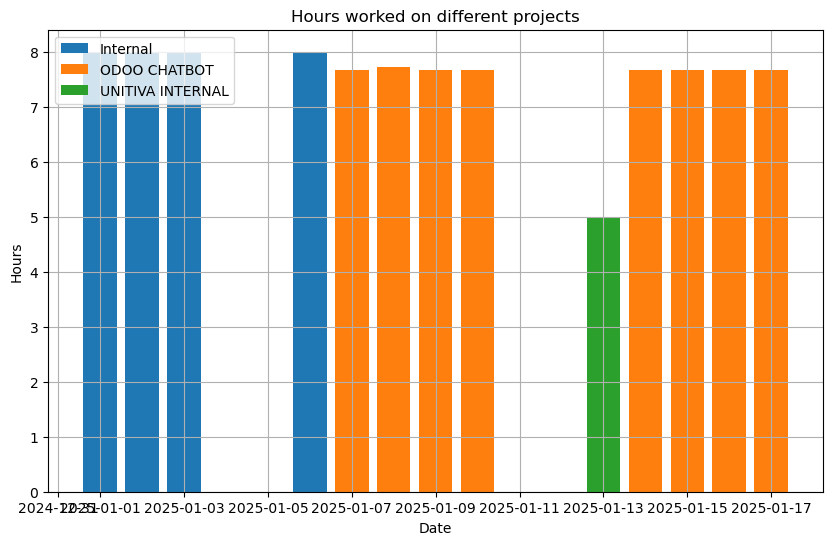

Si è verificato un errore durante la modifica del foglio ore. Sembra che ci sia un problema con l'identificazione del progetto "ODOO CHATBOT". Potrebbe essere necessario verificare che il nome del progetto sia corretto o che esista nel sistema. Vuoi che provi a fare qualcos'altro?


In [24]:
inputs = {
            "messages": [("user", "modifica il foglio ore di oggi, ho lavorato 3 ore al progetto ODOO CHATBOT")]
    }
risposta = invoke_agent(agent,inputs,memory)

print(risposta['messages'][-1].content) 

In [9]:
risposta['messages'][-2]

ToolMessage(content='["Errore durante la modifica del record: {\'code\': 200, \'message\': \'Odoo Server Error\', \'data\': {\'name\': \'psycopg2.errors.InvalidTextRepresentation\', \'debug\': \'Traceback (most recent call last):\\\\n  File \\"/home/odoo/src/odoo/odoo/http.py\\", line 1783, in _serve_db\\\\n    return service_model.retrying(self._serve_ir_http, self.env)\\\\n  File \\"/home/odoo/src/odoo/odoo/service/model.py\\", line 133, in retrying\\\\n    result = func()\\\\n  File \\"/home/odoo/src/odoo/odoo/http.py\\", line 1810, in _serve_ir_http\\\\n    response = self.dispatcher.dispatch(rule.endpoint, args)\\\\n  File \\"/home/odoo/src/odoo/odoo/http.py\\", line 2014, in dispatch\\\\n    result = self.request.registry[\\\\\'ir.http\\\\\']._dispatch(endpoint)\\\\n  File \\"/home/odoo/src/odoo/addons/website/models/ir_http.py\\", line 235, in _dispatch\\\\n    response = super()._dispatch(endpoint)\\\\n  File \\"/home/odoo/src/odoo/odoo/addons/base/models/ir_http.py\\", line 22

In [11]:
if "read_ERP" in risposta['messages'][2].name:
    encrypted_data = risposta['messages'][2].content
    encrypted_data = ast.literal_eval(encrypted_data)

    # Decifra i dati
    decrypted_data = []
    
    for record in encrypted_data:
        decrypted_record = {}
        for key_name, value in record.items():
            decrypted_value = aes_decrypt(value, key, iv)
            decrypted_record[key_name] = decrypted_value
        decrypted_data.append(decrypted_record)

    for i in range(len(encrypted_data)):
        for key_item in encrypted_data[i]:
            encrypted_value = encrypted_data[i][key_item]
            decrypted_value = decrypted_data[i][key_item]

            # Sostituisci il valore cifrato con il valore decifrato nel contenuto
            if isinstance(encrypted_value, bytes):
                encrypted_value_repr = repr(encrypted_value)[2:-1]  # Rappresentazione `bytes` compatibile
                risposta['messages'][-1].content = risposta['messages'][-1].content.replace(encrypted_value_repr, decrypted_value)
      
    print(risposta['messages'][-1].content) 

else:
    print(risposta['messages'][-1].content) 

In [ ]:
risposta

In [ ]:
memory.load_memory_variables({})['chat_history']